In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4109335025144217603
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 50685855360561411
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:0b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

# load data

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

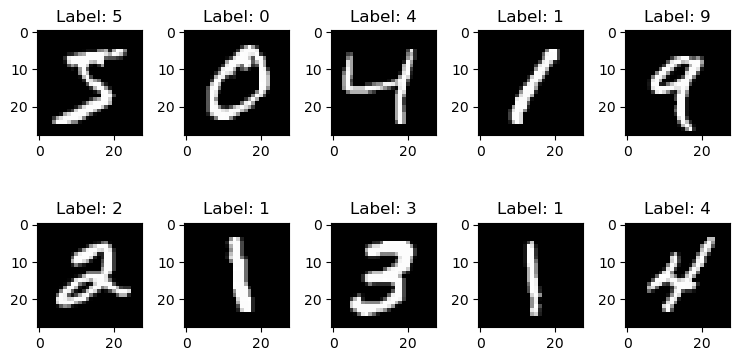

In [4]:
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

# build model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten

In [6]:
x = Input(shape=(28, 28))  # shape of input
z = Flatten()(x)  # 28x28 -> 784
z = Dense(units=128, activation='relu')(z)  # dense + ReLU
p = Dense(units=10, activation='softmax')(z)  # dense + softmax

model = Model(
    inputs=x,
    outputs=p,
)  # build DNN model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])  # compile model

In [7]:
# callbacks
callbacks = [
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath=os.path.join('models', 'DNN', 'test.h5'), save_best_only=True),
]

In [8]:
# train
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 3s 4ms/step - loss: 5.5885 - acc: 0.8596 - val_loss: 1.5793 - val_acc: 0.9168
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 1.0371 - acc: 0.9191 - val_loss: 0.8538 - val_acc: 0.9160
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.5035 - acc: 0.9367 - val_loss: 0.6752 - val_acc: 0.9291
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3148 - acc: 0.9491 - val_loss: 0.5418 - val_acc: 0.9339
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2273 - acc: 0.9571 - val_loss: 0.4978 - val_acc: 0.9366
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1744 - acc: 0.9642 - val_loss: 0.4659 - val_acc: 0.9405
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1504 - acc: 0.9671 - val_loss: 0.4547 - val_acc: 0.9420
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - 

In [9]:
# see accuracy

accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))

313/313 [==============================] - 0s 1ms/step


0.9563

The accuracy of this model is 95.66% (in the author's environment.) Pretty good!

このモデルの精度は（筆者の環境では） 95.66% です。
悪くない！

# compare models

In [10]:
from collections import OrderedDict

class DenseModel:
    def __init__(self, layers=1, hid_dim=128):
        self.input = Input(shape=(28, 28), name='input')
        self.flatten = Flatten(name='flatten')
        self.denses = OrderedDict()
        for i in range(layers):
            name = 'dense_{}'.format(i)
            self.denses[name] = Dense(units=hid_dim, activation='relu', name=name)
        self.last = Dense(units=10, activation='softmax', name='last')
    
    
    def build(self):
        x = self.input
        z = self.flatten(x)
        for dense in self.denses.values():
            z = dense(z)
        p = self.last(z)
        
        model = Model(inputs=x, outputs=p)
        
        return model

In [11]:
dim_hidden_layres = [2**i for i in range(11)]
n_layers = range(1, 4)

df_accuracy = pd.DataFrame()

for layers in n_layers:
    for hid_dim in dim_hidden_layres:
        print('========', 'layers:', layers, '; hid_dim:', hid_dim, '========')
        model = DenseModel(layers=layers, hid_dim=hid_dim)
        model = model.build()
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
        callbacks = [
            EarlyStopping(patience=3),
            ModelCheckpoint(filepath=os.path.join('models', 'DNN', 'model_{}_{}.h5'.format(layers, hid_dim)), save_best_only=True),
        ]
        n_param = model.count_params()
        model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)
        acc = accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))
        
        df_accuracy = pd.concat([df_accuracy, pd.DataFrame([[layers, hid_dim, n_param, acc]], columns=['layers', 'hid_dim', 'n_param', 'accuracy'])])

======== layers: 1 ; hid_dim: 1 ========
Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 2.9207 - acc: 0.1117 - val_loss: 2.3032 - val_acc: 0.1058
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3020 - acc: 0.1138 - val_loss: 2.3022 - val_acc: 0.1059
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3012 - acc: 0.1139 - val_loss: 2.3022 - val_acc: 0.1060
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3011 - acc: 0.1139 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3011 - acc: 0.1139 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3011 - acc: 0.1140 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3010 - acc: 0.1140 - val_loss: 2.3020 - val_acc: 0.1060
Epoch 8/100
375/375 [=======

375/375 [==============================] - 1s 3ms/step - loss: 2.3010 - acc: 0.1140 - val_loss: 2.3023 - val_acc: 0.1060
Epoch 9/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3010 - acc: 0.1140 - val_loss: 2.3022 - val_acc: 0.1060
Epoch 10/100
313/313 [==============================] - 0s 1ms/step
======== layers: 1 ; hid_dim: 8 ========
Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 3.6078 - acc: 0.1256 - val_loss: 2.1824 - val_acc: 0.1689
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 2.1164 - acc: 0.2002 - val_loss: 1.9942 - val_acc: 0.2470
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 1.9648 - acc: 0.2624 - val_loss: 1.8775 - val_acc: 0.2903
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 1.8488 - acc: 0.3027 - val_loss: 1.8011 - val_acc: 0.3477
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 1.5914 - acc: 0.3971 - val_los

Epoch 15/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8162 - acc: 0.7068 - val_loss: 0.8125 - val_acc: 0.7152
Epoch 16/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7784 - acc: 0.7420 - val_loss: 0.7694 - val_acc: 0.7492
Epoch 17/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7321 - acc: 0.7610 - val_loss: 0.7396 - val_acc: 0.7510
Epoch 18/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7015 - acc: 0.7690 - val_loss: 0.6880 - val_acc: 0.7811
Epoch 19/100
375/375 [==============================] - 1s 3ms/step - loss: 0.6854 - acc: 0.7727 - val_loss: 0.6838 - val_acc: 0.7817
Epoch 20/100
375/375 [==============================] - 1s 3ms/step - loss: 0.6693 - acc: 0.7795 - val_loss: 0.6566 - val_acc: 0.7970
Epoch 21/100
375/375 [==============================] - 1s 3ms/step - loss: 0.6609 - acc: 0.7830 - val_loss: 0.6531 - val_acc: 0.7951
Epoch 22/100
375/375 [==============================] - 1s 3ms

Epoch 24/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1069 - acc: 0.9693 - val_loss: 0.2487 - val_acc: 0.9511
Epoch 25/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1105 - acc: 0.9688 - val_loss: 0.2541 - val_acc: 0.9472
Epoch 26/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1009 - acc: 0.9720 - val_loss: 0.2590 - val_acc: 0.9517
Epoch 27/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0969 - acc: 0.9724 - val_loss: 0.2473 - val_acc: 0.9553
Epoch 28/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0907 - acc: 0.9749 - val_loss: 0.2697 - val_acc: 0.9513
Epoch 29/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0881 - acc: 0.9750 - val_loss: 0.2696 - val_acc: 0.9517
Epoch 30/100
313/313 [==============================] - 0s 988us/step
======== layers: 1 ; hid_dim: 128 ========
Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 5.3024 -

313/313 [==============================] - 0s 1000us/step
======== layers: 2 ; hid_dim: 2 ========
Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 2.3036 - acc: 0.1134 - val_loss: 2.3019 - val_acc: 0.1060
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 2.3011 - acc: 0.1140 - val_loss: 2.3020 - val_acc: 0.1060
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 2.3010 - acc: 0.1140 - val_loss: 2.3020 - val_acc: 0.1060
Epoch 4/100
313/313 [==============================] - 0s 994us/step
======== layers: 2 ; hid_dim: 4 ========
Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 2.4157 - acc: 0.1469 - val_loss: 2.0473 - val_acc: 0.1961
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 2.0148 - acc: 0.2035 - val_loss: 1.9812 - val_acc: 0.2028
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 1.9671 - acc: 0.2103 - val_loss: 1.9514 - val_acc: 

Epoch 57/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6251 - acc: 0.3336 - val_loss: 1.6220 - val_acc: 0.3232
Epoch 58/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6255 - acc: 0.3316 - val_loss: 1.6142 - val_acc: 0.3183
Epoch 59/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6246 - acc: 0.3316 - val_loss: 1.6127 - val_acc: 0.3249
Epoch 60/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6233 - acc: 0.3311 - val_loss: 1.6173 - val_acc: 0.3184
Epoch 61/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6220 - acc: 0.3305 - val_loss: 1.6126 - val_acc: 0.3267
Epoch 62/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6215 - acc: 0.3286 - val_loss: 1.6269 - val_acc: 0.3144
Epoch 63/100
375/375 [==============================] - 1s 3ms/step - loss: 1.6215 - acc: 0.3274 - val_loss: 1.6092 - val_acc: 0.3268
Epoch 64/100
375/375 [==============================] - 1s 3ms

375/375 [==============================] - 1s 3ms/step - loss: 0.8248 - acc: 0.7107 - val_loss: 0.8574 - val_acc: 0.6944
Epoch 33/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8153 - acc: 0.7122 - val_loss: 0.8199 - val_acc: 0.7104
Epoch 34/100
375/375 [==============================] - 1s 3ms/step - loss: 0.8030 - acc: 0.7166 - val_loss: 0.7994 - val_acc: 0.7131
Epoch 35/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7875 - acc: 0.7231 - val_loss: 0.7784 - val_acc: 0.7280
Epoch 36/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7755 - acc: 0.7249 - val_loss: 0.7835 - val_acc: 0.7194
Epoch 37/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7637 - acc: 0.7319 - val_loss: 0.7705 - val_acc: 0.7279
Epoch 38/100
375/375 [==============================] - 1s 3ms/step - loss: 0.7578 - acc: 0.7339 - val_loss: 0.7611 - val_acc: 0.7358
Epoch 39/100
375/375 [==============================] - 1s 3ms/step - loss:

Epoch 12/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2562 - acc: 0.9326 - val_loss: 0.3308 - val_acc: 0.9267
Epoch 13/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2412 - acc: 0.9365 - val_loss: 0.2981 - val_acc: 0.9287
Epoch 14/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2321 - acc: 0.9387 - val_loss: 0.3127 - val_acc: 0.9249
Epoch 15/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2293 - acc: 0.9390 - val_loss: 0.2896 - val_acc: 0.9315
Epoch 16/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2216 - acc: 0.9411 - val_loss: 0.2761 - val_acc: 0.9358
Epoch 17/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2116 - acc: 0.9428 - val_loss: 0.2810 - val_acc: 0.9337
Epoch 18/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2059 - acc: 0.9438 - val_loss: 0.2982 - val_acc: 0.9311
Epoch 19/100
313/313 [==============================] - 0s 1ms

Epoch 1/100
375/375 [==============================] - 2s 3ms/step - loss: 3.4693 - acc: 0.9066 - val_loss: 0.3767 - val_acc: 0.9448
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2437 - acc: 0.9568 - val_loss: 0.3167 - val_acc: 0.9520
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1568 - acc: 0.9703 - val_loss: 0.3096 - val_acc: 0.9581
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1433 - acc: 0.9722 - val_loss: 0.3308 - val_acc: 0.9532
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1265 - acc: 0.9757 - val_loss: 0.3226 - val_acc: 0.9553
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1055 - acc: 0.9793 - val_loss: 0.3080 - val_acc: 0.9580
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1051 - acc: 0.9803 - val_loss: 0.2776 - val_acc: 0.9628
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - 

375/375 [==============================] - 1s 3ms/step - loss: 1.4944 - acc: 0.3974 - val_loss: 1.4581 - val_acc: 0.4249
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 1.4427 - acc: 0.4269 - val_loss: 1.4248 - val_acc: 0.4421
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - loss: 1.4056 - acc: 0.4379 - val_loss: 1.3721 - val_acc: 0.4501
Epoch 9/100
375/375 [==============================] - 1s 3ms/step - loss: 1.3771 - acc: 0.4495 - val_loss: 1.3339 - val_acc: 0.4763
Epoch 10/100
375/375 [==============================] - 1s 3ms/step - loss: 1.2357 - acc: 0.5411 - val_loss: 1.1730 - val_acc: 0.5707
Epoch 11/100
375/375 [==============================] - 1s 3ms/step - loss: 1.0904 - acc: 0.6225 - val_loss: 1.0148 - val_acc: 0.6808
Epoch 12/100
375/375 [==============================] - 1s 3ms/step - loss: 0.9832 - acc: 0.6685 - val_loss: 0.9588 - val_acc: 0.6828
Epoch 13/100
375/375 [==============================] - 1s 3ms/step - loss: 0.

Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.4116 - acc: 0.8528 - val_loss: 0.4164 - val_acc: 0.8533
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3915 - acc: 0.8617 - val_loss: 0.4081 - val_acc: 0.8687
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3703 - acc: 0.8835 - val_loss: 0.3755 - val_acc: 0.8913
Epoch 9/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3363 - acc: 0.9004 - val_loss: 0.3709 - val_acc: 0.8997
Epoch 10/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3089 - acc: 0.9124 - val_loss: 0.3324 - val_acc: 0.9104
Epoch 11/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2842 - acc: 0.9199 - val_loss: 0.3221 - val_acc: 0.9144
Epoch 12/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2621 - acc: 0.9260 - val_loss: 0.2888 - val_acc: 0.9247
Epoch 13/100
375/375 [==============================] - 1s 3ms/ste

375/375 [==============================] - 1s 3ms/step - loss: 0.0818 - acc: 0.9788 - val_loss: 0.1702 - val_acc: 0.9651
Epoch 10/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0660 - acc: 0.9816 - val_loss: 0.1792 - val_acc: 0.9667
Epoch 11/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0597 - acc: 0.9842 - val_loss: 0.1615 - val_acc: 0.9667
Epoch 12/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0473 - acc: 0.9867 - val_loss: 0.1830 - val_acc: 0.9625
Epoch 13/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0620 - acc: 0.9836 - val_loss: 0.1766 - val_acc: 0.9646
Epoch 14/100
313/313 [==============================] - 0s 1ms/step
======== layers: 3 ; hid_dim: 1024 ========
Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 2.5109 - acc: 0.8994 - val_loss: 0.2161 - val_acc: 0.9445
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1287 - acc: 0.9625 - 

In [18]:
display(df_accuracy.set_index(['layers', 'hid_dim'])[['n_param']].unstack())
display(df_accuracy.set_index(['layers', 'hid_dim'])[['accuracy']].unstack())

n_param                                                         \
hid_dim    1     2     4     8      16     32     64      128     256    
layers                                                                   
1           805  1600  3190  6370  12730  25450  50890  101770  203530   
2           807  1606  3210  6442  13002  26506  55050  118282  269322   
3           809  1612  3230  6514  13274  27562  59210  134794  335114   

                          
hid_dim    512      1024  
layers                    
1        407050   814090  
2        669706  1863690  
3        932362  2913290

accuracy                                                          \
hid_dim     1       2       4       8       16      32      64      128    
layers                                                                     
1         0.1135  0.1135  0.3034  0.8084  0.8856  0.9438  0.9503  0.9521   
2         0.1135  0.1136  0.1135  0.6219  0.9037  0.9368  0.9442  0.9465   
3         0.1135  0.3898  0.1134  0.8490  0.9203  0.9504  0.9592  0.9619   

                                 
hid_dim    256     512     1024  
layers                           
1        0.9583  0.9617  0.9687  
2        0.9671  0.9577  0.9661  
3        0.9583  0.9687  0.9659

In [14]:
df_accuracy.to_csv('dnn_results.csv')